# Prototype for CFIUS Review Data Collection
Author: Jiayan Li

Date: June 9, 2024

This script implements the following data pipeline:

1. Scrape EDGAR for 8-K Filings:
- Identify 8-K filings within a specified timeframe that contain the keyword 'CFIUS'.
- Extract relevant company information and format the URLs for the 8-K form scraping.

2. Extract Relevant Texts:
- Retrieve and extract texts surrounding the keyword 'CFIUS' from the identified 8-K filings.

3. Classify Extracted Texts:
- Use a Transformers model to classify the extracted texts.

In [19]:
import pandas as pd
import re
import requests
from datetime import datetime, timedelta
from typing import List, Dict, Optional
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
import time
from bs4 import BeautifulSoup
warnings.filterwarnings('ignore')

# Importing the helper functions from the utils.py file
from utils import *

## Find relevant 8-K filings

To get all 8-K filings beyond the most recent 1000 or those within a specific timeframe, I needed to use the EDGAR Full Text Search API. This allows us to query for specific filings over an extended period and handle pagination to retrieve more than the initial limit. I followed these steps:

1. Define the search parameters either by start date (end date) or recent_n_day.
2. Fetch all the data that satisfies the parameters (8-K forms with the keyword 'CFIUS', within the specified time range, since 2021).
3. Extract the relevant information including company name, etc., from the fetched data.
4. Formulate the URLs of the 8-K forms for collecting textual data.

*Alternative Strategy: Use Selenium to dynamically scrape the site [SEC EDGAR Search](https://www.sec.gov/edgar/search/#/q=CFIUS&category=custom&forms=8-K)*

In [3]:
# Define the base URL for the EDGAR Full Text Search API
base_url = "https://efts.sec.gov/LATEST/search-index"

# Set up headers, including a User-Agent as required by the SEC EDGAR API guidelines
headers = {
    "User-Agent": "Contact: jiayanjoanneli@gmail.com",
    "Accept-Encoding": "gzip, deflate",
    "Host": "efts.sec.gov"
}

In [4]:
# Define the search parameters
def define_search(end_date: Optional[str] = None,
                  start_date: Optional[str] = None,
                  recent_n_day: Optional[int] = None,
                  keyword: str = 'CFIUS',
                  forms: List[str] = ["8-K"]
                  ) -> dict:
    """
    Define the search parameters for the EDGAR Full Text Search API.
    Args:
        end_date (str): The end date for the search in the format 'YYYY-MM-DD'.
        start_date (str): The start date for the search in the format 'YYYY-MM-DD'.
        recent_n_day (int): The number of recent days to search.
        keyword (str): The keyword to search for in the filings.
        forms (list): A list of form types to search for.
    Returns:
        dict: The search parameters for the API.
    """

    # Check if the start date or recent_n_day parameter is provided
    if start_date is not None and recent_n_day is not None:
        raise ValueError("Both start_date and recent_n_day parameters cannot be provided.")
    
    # Set the end date to today if not provided
    if end_date is None:
        end_date = datetime.now()
        end_date_str = end_date.strftime('%Y-%m-%d')
    else:
        end_date_str = end_date

    # Calculate the start date based on the recent_n_day parameter
    if recent_n_day is not None:
        start_date = end_date - timedelta(days=recent_n_day)
        start_date_str = start_date.strftime('%Y-%m-%d')
    elif start_date is not None:
        start_date_str = start_date
    else:
        raise ValueError("Invalid parameters provided.")

    # Define the parameters for the search
    params = {
        "dateRange": "custom",
        "startdt": start_date_str,
        "enddt": end_date_str,
        "category": "custom",
        "forms": forms,
        "q": keyword,   # Search keyword
        "from": 0,
        "size": 100
    }

    return params


# Function to fetch filings
def fetch_filings(params: Dict[str, any],
                  base_url: str = "https://efts.sec.gov/LATEST/search-index",
                  headers: Dict[str, str] = headers
                  ) -> List:
    """
    Fetch 8-K filings from the SEC EDGAR Full Text Search API.
    Args:
        params (dict): The search parameters for the API.
        base_url (str): The base URL for the API endpoint.
        headers (dict): The headers to be included in the request.
    Returns:
        list: A list of filings retrieved from the API.
    """

    filings = []
    while True:
        # Send a GET request to the API endpoint
        response = requests.get(base_url, headers=headers, params=params)
        
        # Check if the request was successful
        if response.status_code == 200:
            print(f"Fetching data from {params['from']} to {params['from'] + params['size']}")
            # Parse the JSON response
            data = response.json()
            
            # Extract the filings
            hits = data.get('hits', {}).get('hits', [])
            if not hits:
                break
            filings.extend(hits)
            
            # Check if there are more results to fetch
            if len(hits) < params['size']:
                break
            
            # Update the 'from' parameter to fetch the next set of results
            params['from'] += params['size']
        else:
            print(f"Failed to retrieve data. Status code: {response.status_code}")
            break
    
    return filings

In [5]:
# Fetch all 8-K filings with keyword 'CFIUS'
params = define_search(start_date='2021-01-01')
all_filings = fetch_filings(params)

Fetching data from 0 to 100
Fetching data from 100 to 200
Fetching data from 200 to 300
Fetching data from 300 to 400
Fetching data from 400 to 500
Fetching data from 500 to 600


In [6]:
def construct_filings_df(all_filings: list) -> pd.DataFrame:
    """
    Construct a DataFrame with the relevant information from the filings in search result.
    Args:
        all_filings (list): A list of filings retrieved from the API.
    Returns:
        pd.DataFrame: A DataFrame containing the relevant information from the filings.
    """
    
    filing_data = []
    for filing in all_filings:
        source = filing.get('_source', {})
        file_name = transform_filename(filing.get('_id', ''))
        if source and file_name:
            # Extract the relevant information
            cik = source.get('ciks', [''])[0] 
            company = source.get('display_names', [''])[0]
            try:
                company_name, ticker, _ = extract_info(company)
            except:
                print(company)
                company_name, ticker = None, None
            filing_date = source.get('file_date', '')
            form = source.get('form', '')
            file_type = source.get('file_type', '')
            file_description = source.get('file_description', '')
            items = source.get('items', [])
            url = f"https://www.sec.gov/Archives/edgar/data/{cik.lstrip('0')}/{file_name}"
            
            # Construct a dictionary with the data
            filing_info = {
                "cik": cik,
                "company_name": company_name,
                "ticker": ticker,
                "form": form,
                "filing_date": filing_date,
                "file_type": file_type,
                "file_description": file_description,
                "items": items,
                "form_url": url
            }

            # Append the dictionary to the list
            filing_data.append(filing_info)

        # Create a DataFrame from the list of dictionaries
        df = pd.DataFrame(filing_data)

    return df

In [58]:
df = construct_filings_df(all_filings)

# Exclude the exhibits
df_8k = df[(df['form'] == '8-K') & (~df['file_type'].str.contains('EX'))].reset_index(drop=True)
print(f"Total number of 8-K filings (excl. exhibits): {len(df_8k)}")
df_8k.head()

Total number of 8-K filings (excl. exhibits): 116


,cik,company_name,ticker,form,filing_date,file_type,file_description,items,form_url
0,0001566373,"F-star Therapeutics, Inc.",FSTX,8-K,2022-12-21,8-K,8-K,"[1.01, 8.01, 9.01]",https://www.sec.gov/Archives/edgar/data/156637...
1,0001680048,"MUSTANG BIO, INC.",MBIO,8-K,2024-03-29,8-K,FORM 8-K,[8.01],https://www.sec.gov/Archives/edgar/data/168004...
2,0001325702,MAGNACHIP SEMICONDUCTOR Corp,MX,8-K,2021-10-29,8-K,8-K,[8.01],https://www.sec.gov/Archives/edgar/data/132570...
3,0001325702,MAGNACHIP SEMICONDUCTOR Corp,MX,8-K,2021-09-14,8-K,8-K,[8.01],https://www.sec.gov/Archives/edgar/data/132570...
4,0001883962,ALSP Orchid Acquisition Corp I,"ALOR, ALORU, ALORW",8-K,2022-11-30,8-K,8-K,[8.01],https://www.sec.gov/Archives/edgar/data/188396...


## Extract relevant text in 8-K filings

My extraction strategy includes:
1. Fetch HTML content using `requests` library.
2. Parse the HTML content using `BeautifulSoup`.
3. Extract relevant text based on the keyword 'CFIUS' and the surrounding text.
4. Combine the extracted text into a single string and add to the DataFrame.

*Note: Only the extracted relevant text is saved in this pipeline for saving storage space. Change `save` parameter to save 8-K forms to local.*

In [59]:
def get_sec_soup(url: str, headers: dict = headers_sec, save: bool = False) -> BeautifulSoup:
    """
    Get the BeautifulSoup object for a given SEC filing URL.
    Args:
        url (str): The URL of the SEC filing.
        headers (dict): The headers to be included in the request.
        save (bool): Whether to save the HTML content to a file.
    Returns:
        BeautifulSoup: The parsed HTML content of the SEC filing.
    """

    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        if save:
            with open(f"{url.split('/')[-1]}.html", 'w') as f:
                f.write(response.text)
        return BeautifulSoup(response.text, 'html.parser')
    else:
        raise Exception(f"Error {response.status_code}: Unable to retrieve data from {url}")

In [60]:
def extract_context_around_keyword(soup: BeautifulSoup, 
                                   context_tags: int, 
                                   keyword: str = 'CFIUS', 
                                   tags_to_search=['p', 'td', 'div']) -> str:
    """
    Extract the context around a keyword in the text of an HTML document. 
    Note that only the first occurrence of the keyword is considered.
    Args:
        soup (BeautifulSoup): The BeautifulSoup object containing the parsed HTML content.
        context_tags (int): The number of context tags to extract before and after the keyword.
        keyword (str): The keyword to search for in the text.
        tags_to_search (list): A list of HTML tags to search for the keyword.
    Returns:
        str: The extracted context around the keyword. 
    """

    # Find all tags of the specified type
    tags = soup.find_all(tags_to_search)
    
    # Initialize an empty list to store the context
    context = []
    
    # Loop through the tags to find the keyword and extract context
    for i, element in enumerate(tags):
        if keyword in element.get_text():
            # Get the start and end indices for the context
            start_index = max(0, i - context_tags)
            end_index = min(len(tags), i + context_tags + 1)
            
            # Extract the context tags
            context_tags = tags[start_index:end_index]
            
            # Add the text of each context tag to the context list
            for context_tag in context_tags:
                text = context_tag.get_text()
                # Check if there are alphabets in text
                if re.search('[a-zA-Z]', text):
                    context.append(re.sub(r'\s+', ' ', text))

            break
    
    # Join the context into a single string
    context_string = " ".join(context)
    
    return context_string

In [61]:
url = df_8k['form_url'].values[0]
print(url)
soup = get_sec_soup(url)
context = extract_context_around_keyword(soup, context_tags=1)
print(context)

https://www.sec.gov/Archives/edgar/data/1566373/000119312522309500/d439272d8k.htm
 Item 1.01 Entry into a Material Definitive Agreement. Amendment No. 3 to Merger Agreement with invoX Pharma On December 20, 2022, F-star Therapeutics, Inc., a Delaware corporation (the “Company”), invoX Pharma Limited, a private limited company organized under the laws of England and Wales (“Parent”) and Fennec Acquisition Incorporated, a Delaware corporation and a wholly owned subsidiary of Parent (“Purchaser” and together with the Company and Parent, the “Parties”), entered into Amendment No. 3 (“Amendment No. 3”) to the Agreement and Plan of Merger, dated as of June 22, 2022, by and among the Parties and Sino Biopharmaceutical Limited, a company organized under the laws of the Cayman Islands, as “Guarantor” (the “Merger Agreement”). Pursuant to Amendment No. 3, the Parties have agreed to reduce one of Parent’s conditions to its obligation to complete the Offer as set forth in Annex I of the Merger Agr

## Data Labeling: Running Transformer Model on Extracted Text

I processed the extracted text through the `transformers` pipeline to classify it. This pipeline utilizes the pre-trained model `roberta-large-mnli` [available on Hugging Face](https://huggingface.co/facebook/roberta-large-mnli) to categorize the text into one of the following classifications:
- CFIUS review announced (without a final determination)
- Notices of CFIUS approvals
- Notices of CFIUS denials
Only the class with the highest confidence score is selected as the final classification.

*Note: The model can be easily swapped with larger and more sophisticated models, such as Llama3. Additionally, fine-tuning the model with human-labeled data is recommended for better accuracy.*

In [5]:
def label_filing(df_8k: pd.DataFrame,
                 rerun: bool = False,
                 save_8k: bool = False) -> pd.DataFrame:
    """
    Extract relevant text from each form and classify it. This function 
    pulls the newest data from edgar and appends to the existing data.
    Args:
        df_8k (pd.DataFrame): The DataFrame containing the 8-K filings.
        rerun (bool): Whether to rerun the classification for all filings.
        save_8k (bool): Whether to save the DataFrame to a CSV file.
    Returns:
        pd.DataFrame: The DataFrame with the relevant text and classification results.
    """
    
    # Check if the cache exists
    if os.path.exists('data/8k_labeled.csv') and not rerun:
        df_cache = pd.read_csv('data/8k_labeled.csv')
        # Concatenate the two DataFrames vertically
        df_8k = pd.concat([df_8k, df_cache], axis=0)

        # Remove duplicate entries based on 'form_url' and reset the index
        df_8k.drop_duplicates(subset='form_url', keep='last', inplace=True)
        df_8k.reset_index(drop=True, inplace=True)
    else:
        # Initialize a new column to store the relevant text, label, and score
        df_8k['relevant_text'] = ""
        df_8k['label'] = ""
        df_8k['score'] = 0.0

    for i, row in df_8k.iterrows():
        if i % 10 == 0:
            print(f"Processing filing {i+1}/{len(df_8k)}")

        # If the row has already been processed, skip it
        if row['label']:
            continue
        
        url = row['form_url']
        soup = get_sec_soup(url, save=save_8k)  # Assuming this is a function to get the parsed HTML content
        relevant_text = extract_context_around_keyword(soup, context_tags=1)  # Assuming this function extracts relevant text

        # If extraction is not successful
        if not relevant_text:
            df_8k.to_csv('data/8k_labeled.csv', index=False)
            return df_8k.at[i, 'form_url']

        else:
            # Update the 'relevant_text' column using the DataFrame's 'at' method
            df_8k.at[i, 'relevant_text'] = relevant_text
            result = zero_shot_classification(relevant_text)  # Assuming this function returns classification results
            df_8k.at[i, 'label'] = result['labels'][0]
            df_8k.at[i, 'score'] = result['scores'][0]

    df_8k.to_csv('data/8k_labeled.csv', index=False)

    return df_8k

In [63]:
df_8k = label_filing(df_8k)

Processing filing 1/116
Processing filing 11/116
Processing filing 21/116
Processing filing 31/116
Processing filing 41/116
Processing filing 51/116
Processing filing 61/116
Processing filing 71/116
Processing filing 81/116
Processing filing 91/116
Processing filing 101/116
Processing filing 111/116


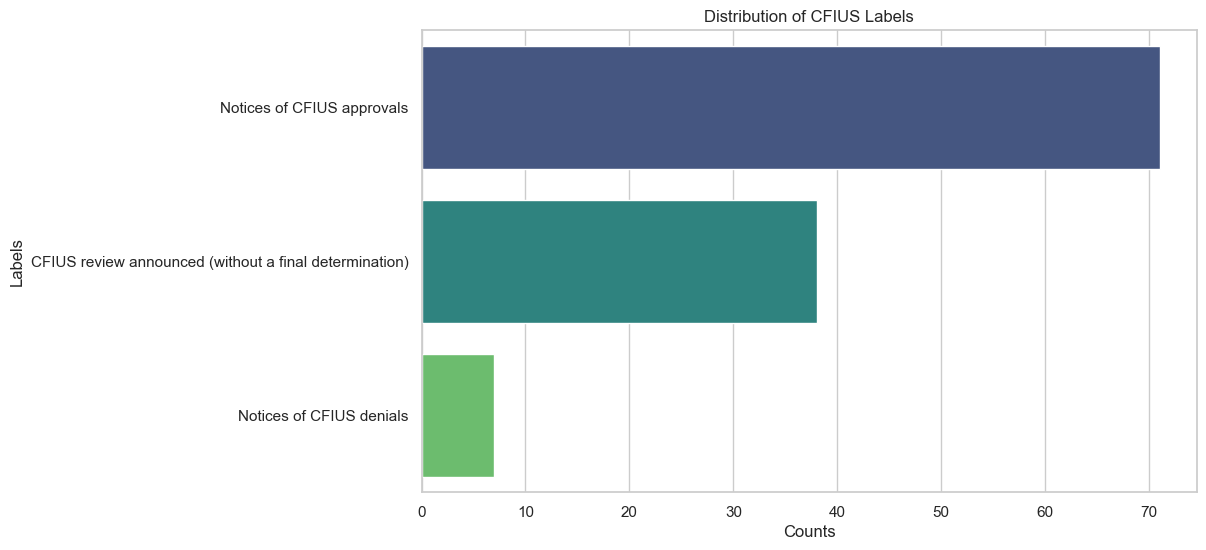

In [65]:
# Plotting
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Create the count plot
sns.countplot(y=df_8k[df_8k['label'].str.len() != 0]['label'], palette="viridis")

# Add title and labels
plt.title('Distribution of CFIUS Labels')
plt.xlabel('Counts')
plt.ylabel('Labels')

# Display the plot
plt.show()

## Consolidate the pipeline
Consolidate the pipeline into a single command for user convenience. 

In [7]:
def label_cfius_reviews(end_date: Optional[str] = None,
                        start_date: Optional[str] = None,
                        recent_n_day: Optional[int] = None,
                        rerun: bool = False,
                        save_8k: bool = False
                        ) -> pd.DataFrame:
    """
    Fetch all 8-K forms filed within a timeframe relevant to CFIUS, extract relevant texts, 
    and classify the CIFUS reviews into announcement, approval, and denial.
    Args:
        end_date (str): The end date for the search in the format 'YYYY-MM-DD'.
        start_date (str): The start date for the search in the format 'YYYY-MM-DD'.
        recent_n_day (int): The number of recent days to search.
        rerun (bool): Whether to rerun the classification for all filings.
        save_8k (bool): Whether to save the DataFrame to a CSV file.
    Returns:
        pd.DataFrame: The DataFrame with the relevant text and classification results.
    """

    # Data collection
    params = define_search(end_date=end_date, start_date=start_date, recent_n_day=recent_n_day)
    all_filings = fetch_filings(params)

    # Data engineering
    df = construct_filings_df(all_filings)
    df_8k = df[(df['form'] == '8-K') & (~df['file_type'].str.contains('EX'))].reset_index(drop=True)

    # Data modeling
    df_8k = label_filing(df_8k, rerun=rerun, save_8k=save_8k)

    return df_8k

Call this function to run the entire end-to-end pipeline and get the final classification results. Last run on June 9 2024.

In [34]:
df_8k = label_cfius_reviews(start_date='2021-01-01', rerun=False, save_8k=False)

Fetching data from 0 to 100
Fetching data from 100 to 200
Fetching data from 200 to 300
Fetching data from 300 to 400
Fetching data from 400 to 500
Fetching data from 500 to 600
Processing filing 1/116
Processing filing 11/116
Processing filing 21/116
Processing filing 31/116
Processing filing 41/116
Processing filing 51/116
Processing filing 61/116
Processing filing 71/116
Processing filing 81/116
Processing filing 91/116
Processing filing 101/116
Processing filing 111/116
